In [1]:
%matplotlib inline

user-defined LaTeX commands
$\newcommand{\Er}{\mathcal{E}}$
$\newcommand{\Xset}{\mathcal{X}}$
$\newcommand{\Yset}{\mathcal{Y}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\l}{\mathcal{l}}$
$\newcommand{\pr}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\D}{\mathbb{D}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\I}{\mathbf{I}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\e}{\mathbf{e}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\v}{\mathbf{v}}$
$\newcommand{\phivec}{\boldsymbol{\phi}}$
$\newcommand{\sign}{\mathrm{sign}}$
$\newcommand{\z}{\mathbf{z}}$
$\newcommand{\Y}{\mathbf{Y}}$
$\newcommand{\Z}{\mathbf{Z}}$
$\newcommand{\a}{\mathbf{a}}$
$\newcommand{\W}{\mathbf{W}}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from ggplot import *

In [4]:
from matplotlib import colors as clrs
from matplotlib.colors import ListedColormap

In [5]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.stats import beta

In [7]:
from scipy.stats import mode

### Brier score

Consider binary output events. Suppose, we have an expert, who can forecast the outcome, providing some probability of it.
Possible outcomes are $\displaystyle{\{0,1\}}$.  
Let's define so called *Brier score*: $\displaystyle{S_B=\frac{1}{n}\sum_{i=1}^n(f_i-o_i)^2}$, where $f_i$ - forecasted probability of event, $o_i$ - actual outcome.

In [8]:
def brier_score(p, y):
    return np.sum ((p - y) ** 2 / len (p))

#### Brier score special cases:

**Note:** expert, who just uses constant prediction: "probability of event is 50%" has a Brier score 0.25 

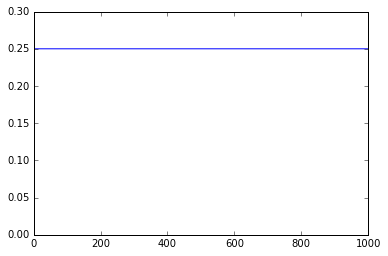

In [9]:
n = 1000
y = bernoulli.rvs (p = 0.5, size = n)
p = np.array([0.5] * n)
score =[brier_score (p[:i], y[:i]) for i in range (n)]
plt.plot (score);

**Note:** more general - expert, who just uses constant prediction: "probability of event is p", 
where $p$ is an actual probability of event, has a Brier score $p(1-p)$. 
This is the *best possible* score in the case of *independent* events. 

0.09000000000000001


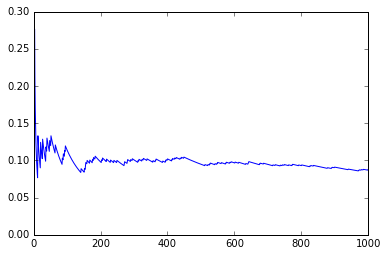

In [10]:
n = 1000
prob = 0.1
y = bernoulli.rvs(p=prob, size=n)
p = np.array([prob] * n)
score = [brier_score(p[:i], y[:i]) for i in range(n)]
plt.plot(score);
print(prob * (1 - prob))

**Note:** expert, who uses constant prediction: "probability of event is $p$", while the actual probability of 
independent events is $p_0$, has a Brier score $(1-p_0)\cdot p^2+p_0\cdot (1-p)^2$

0.14999999999999997


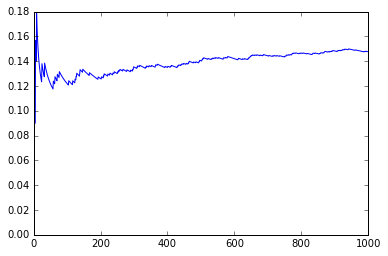

In [11]:
n = 1000
prob = 0.15
p_pred = 0.3
y = bernoulli.rvs(p=prob, size=n)
p = np.array([p_pred] * n)
score =[brier_score (p[:i], y[:i]) for i in range (n)]
plt.plot (score);
print((p_pred ** 2 * (1 - prob) + prob * (1 - p_pred) ** 2))

**Note:** expert, who just uses coin tossing for prediction, has a Brier score 0.5

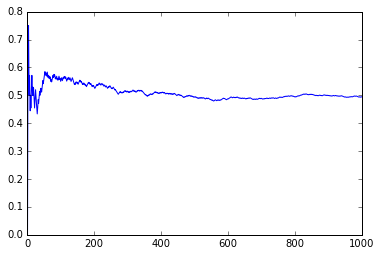

In [12]:
n = 1000
y = bernoulli.rvs (p = 0.5, size = n)
p = bernoulli.rvs (p = 0.5, size = n)
score =[brier_score (p[:i], y[:i]) for i in range (n)]
plt.plot (score);

**Note:** expert, who uses uniform random guess for prediction, has a Brier score $1/3$

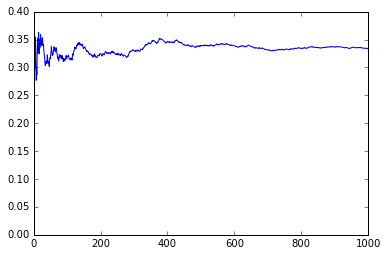

In [12]:
n = 1000
y = bernoulli.rvs (p = 0.5, size = n)
p = uniform.rvs(size=n)
score =[brier_score (p[:i], y[:i]) for i in range (n)]
plt.plot (score);

#### Simulation of an expert with a given Brier score

* Let's simulate an expert with a given Brier score $S_B=s$. 
* We'll take Beta distribution $\xi\sim\mathrm{B}(\alpha,\beta)$ as a model one.
* Suppose outcome is $o=0$, how to model expert probability estimate $f$ in this case? 
$$\displaystyle{S_B=\frac{1}{n}\sum_{i=1}^nf_i^2=\mathbb{E}\xi^2=s}$$ 
* Second order moment for Beta distribution is expressed:
$$\displaystyle{\mathbb{E}\xi^2=\frac{\alpha+1}{\alpha+\beta+1}\frac{\alpha}{\alpha+\beta}=s},$$
where the last equality is due to our constraint on Brier score.
* Suppose $\beta=\kappa\alpha$, for some real value $\kappa$.
* Taking $\alpha=1$, one can get $\displaystyle{\beta=-\frac{1}{2}\left(3-\sqrt{1+\frac{8}{s}}\right)}$.

In [13]:
class Expert(object):

    def __init__(self, brier_score = 0.5):
        self.brier_score_ = brier_score
        self.a = 1.
        self.b = (- 3. + np.sqrt (1. + 8. / self.brier_score_)) / 2.

    def predict(self, y):
        y_prob =[beta.rvs (self.a, self.b) if yi == 0 else beta.rvs (self.b, self.a) for yi in y]
        return np.array(y_prob)

**Check that mean score equals given:**

In [14]:
clf = Expert(brier_score=0.15)

In [15]:
score =[]
for i in range (1000):
    y = bernoulli.rvs (p = 0.1, size = 100)
    p = clf.predict (y)
    score.append(brier_score(p,y))
score = np.array (score)
print (np.mean (score), np.std (score))

0.150409785749 0.0177014284576


In [16]:
clf = Expert(brier_score=0.1)
y = bernoulli.rvs(p=0.9, size=100)
p = clf.predict (y)

Here is how actual outcomes are plotted over expert predictions

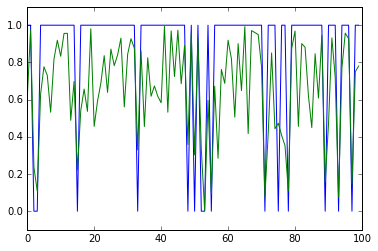

In [17]:
plt.plot (y)
plt.plot (p)
plt.ylim(-0.1, 1.1);

Limit behaviour of expert's predictions:

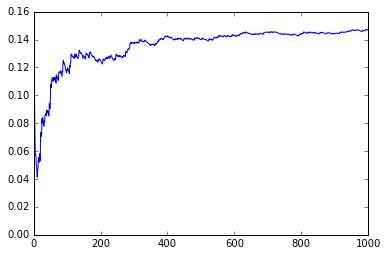

In [18]:
n = 1000
prob = 0.1
clf = Expert(brier_score=0.15)
y = bernoulli.rvs (p = prob, size = n)
p = clf.predict (y)
score =[brier_score (p[:i], y[:i]) for i in range (n)]
plt.plot (score);

Let's plot the correlation between expert's score and probability of *Bernoulli* event.

* Take ranges for probabilities and scores

In [19]:
n = 1000
probs = np.linspace(0.01, 0.99, 20)
scores = np.linspace(0.01, 0.99, 20)

* Define the step function

In [20]:
def step_function(x, margin = 0, label =[0, 1]):
    return np.where (x >= margin, label[1], label[0])

* Define the function, which will calculate the correlations between probabilities and scores

In [21]:
@np.vectorize
def BScorr(prob, score, n=1000):
    clf = Expert(brier_score=score)
    y = bernoulli.rvs(p=prob, size=n)
    p = step_function(clf.predict(y), 0.5)
    return np.corrcoef(np.vstack((y, p)))[0][1]

* For each point in the grid compute the resulting correlation

In [22]:
p, s = np.meshgrid(probs, scores)
z = BScorr(p,s)

* Plot the correlation plot

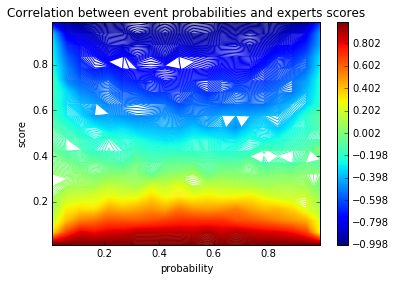

In [23]:
levels = np.arange(np.min(z),np.max(z),0.005)

plt.contour(p,s,z, levels=levels)
plt.xlabel('probability')
plt.ylabel('score')
plt.title('Correlation between event probabilities and experts scores')
plt.colorbar();

Output-prediction correlation for fixed Brier score

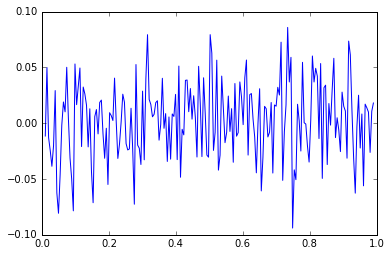

In [49]:
score = 1. / 3.
probs = np.linspace(0.01, 0.99, 200)
scores = np.array([score] * len(probs))
z = BScorr(probs, scores)
plt.plot(probs, z);

Output-prediction correlation for fixed event probability

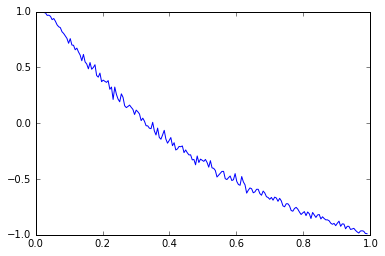

In [50]:
prob = 0.5
scores = np.linspace(0.01, 0.99, 200)
probs = np.array([prob] * len(scores))
z = BScorr(probs, scores)
plt.plot(scores, z);

Consider an expert, who makes always *constant* predictions for Bernoulli events

In [51]:
@np.vectorize
def Bscore(r0, r):
    return (1 - r0) * r ** 2 + r0 * (1 - r) ** 2

In [54]:
r = r0 = np.linspace(0.01, 0.99, 100)
r, r0 = np.meshgrid(r, r0)
z = Bscore(r, r0)

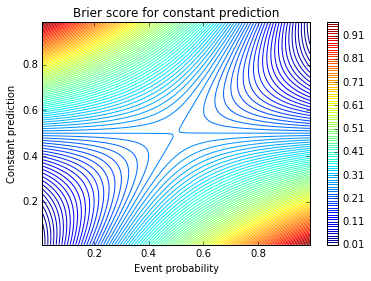

In [58]:
levels = np.arange(np.min(z),np.max(z),0.01)
plt.contour(r, r0, z, levels=levels)
plt.xlabel('Event probability')
plt.ylabel('Constant prediction')
plt.title('Brier score for constant prediction')
plt.colorbar();

### Wisdom of crowds

Let's create several experts with moderate Brier scores and improve their accuracy with the help of *majority vote* rule:
* **take prediction, supported by the majority of experts.**

Define a group of *fair* experts.

In [24]:
fair = np.linspace(0.15, 0.2, 7)

In [25]:
class EnsembleExpert(object):

    def __init__(self, num_experts=7, scores_range=np.linspace(0.15, 0.2, 7)):
        self.experts =[]
        self.scores =[]
        self.num_experts = num_experts
        self.scores_range = scores_range
        for i in range (self.num_experts):
            brier_score = np.random.choice (self.scores_range)
            self.scores.append (brier_score)
            self.experts.append (Expert (brier_score))

    def predict(self, y):
        n = y.shape[0]
        self.X = np.zeros (n * self.num_experts).reshape (n, self.num_experts)
        for expert in range (self.num_experts):
            self.X[:, expert] = step_function (self.experts[expert].predict (y), 0.5)
        self.y_prob = np.array (mode (self.X, axis = 1).mode).reshape (- 1)
        return self.y_prob

In [26]:
y = bernoulli.rvs(p=0.1, size=100)
ee = EnsembleExpert(scores_range=fair)
y_prob = ee.predict (y)

In [27]:
print(np.array(ee.scores))

[ 0.15833333  0.16666667  0.2         0.18333333  0.15        0.16666667
  0.2       ]


*Ensemble expert* predicts better, than each expert in the group:

In [28]:
brier_score(y_prob, y)

0.10000000000000001

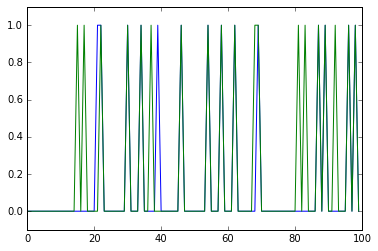

In [67]:
plt.plot (y)
plt.plot (y_prob)
plt.ylim(-0.1, 1.1);

Consider a number of *poor* experts:

In [30]:
poor = np.linspace(0.25, 0.5, 7)

In [31]:
y = bernoulli.rvs(p=0.1, size=100)
ee = EnsembleExpert(scores_range=poor)
y_prob = ee.predict (y)

In [32]:
print(np.array(ee.scores))

[ 0.25        0.375       0.33333333  0.41666667  0.33333333  0.5         0.375     ]


Our version of ensemble expert makes prediction even worser:

In [33]:
brier_score(y_prob, y)

0.53000000000000003

Consider a weighted version of ensemble expert: let's weight expert's predictions, according to their Brier scores

In [34]:
def invert(y):
    return 1.0 - y

In [35]:
class WeightedEnsembleExpert(object):

    def __init__(self, num_experts = 7, scores_range = np.linspace (0.3, 0.45, 7), rule = 'majority vote'):
        self.rule = rule
        self.experts =[]
        self.scores =[]
        self.num_experts = num_experts
        self.scores_range = scores_range
        self.rule = rule
        for i in range (self.num_experts):
            brier_score = np.random.choice (self.scores_range)
            self.scores.append (brier_score)
            self.experts.append (Expert (brier_score))
        adj_scores = np.exp (np.abs (np.array (self.scores) - 0.5))
        self.weights = np.array (adj_scores) / np.sum (np.array (adj_scores))

    def predict(self, y):
        n = y.shape[0]
        self.X = np.zeros (n * self.num_experts).reshape (n, self.num_experts)
        for expert in range (self.num_experts):
            if self.experts[expert].brier_score_ <= 1. / 3.:
                self.X[:, expert] = step_function (self.experts[expert].predict (y), 0.5)
            else:
                self.X[:, expert] = step_function (invert (self.experts[expert].predict (y)), 0.5)
        if self.rule == 'majority vote':
            self.y_prob = np.array (mode (self.X, axis = 1).mode).reshape (- 1)
        elif self.rule == 'weighted':
            self.y_prob = np.array (np.average (self.X, axis = 1, weights = self.weights)).reshape (- 1)
        return self.y_prob

In [36]:
y = bernoulli.rvs (p = 0.1, size = 100)
ee = WeightedEnsembleExpert (scores_range = poor, rule = 'weighted')
y_prob = ee.predict (y)

Scores of our group of experts are:

In [37]:
print (ee.scores)

[0.41666666666666663, 0.5, 0.375, 0.33333333333333331, 0.25, 0.29166666666666669, 0.25]


Our weighted ensemble score is:

In [38]:
brier_score (y_prob, y)

0.2104139749151826

We also obtained fair accuracy score using our weighted ensemble expert:

In [78]:
print(accuracy_score(y, step_function(y_prob, 0.5)))

0.62
